# Import Required Libraries

In [1]:
# import sys
# import os
# os.chdir("..")
# os.chdir("..")
# os.chdir("./src")
# # sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSSv3 import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
np.random.seed(100)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Sparse'

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.00082636032279


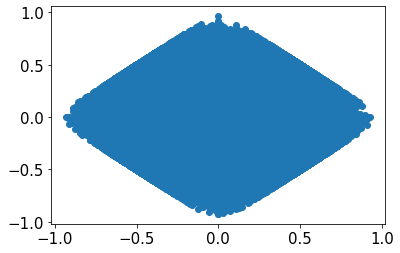

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources

SNRlevel = 30 # dB
NoiseAmp = (10 ** (-SNRlevel/20))

S = 2*np.random.uniform(size = (NumberofSources,int(N)))-1
S = ProjectRowstoL1NormBall(S.T).T
INPUT_STD = 0.5
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for MM in range(A.shape[0]):
    stdx = np.std(X[MM,:])
    A[MM,:] = A[MM,:]/stdx * INPUT_STD
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNRlevel/20)*INPUT_STD
X=Xn+Noisecomp

SNRinp = 20*np.log10(np.std(Xn)/np.std(Noisecomp))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

# Visualize Generated Sources and Mixtures

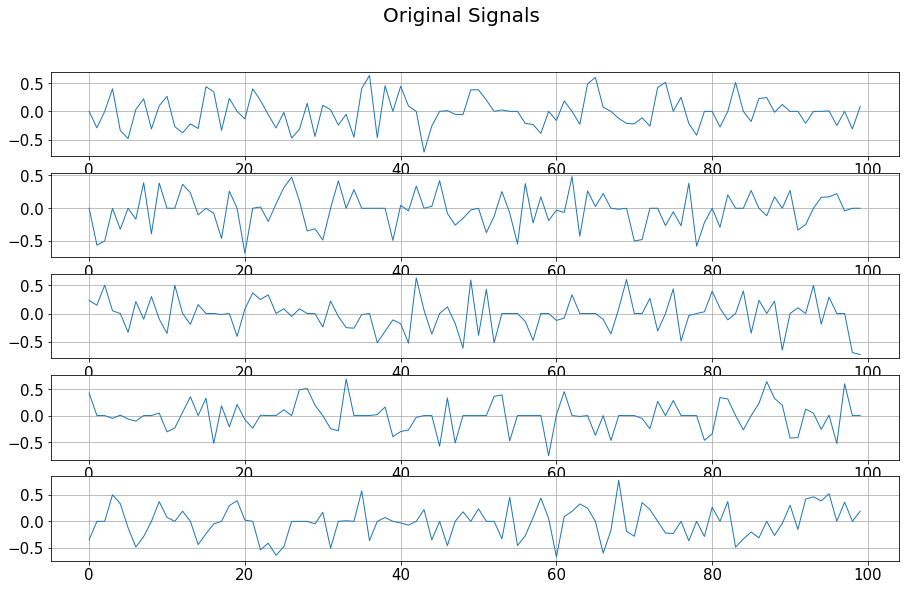

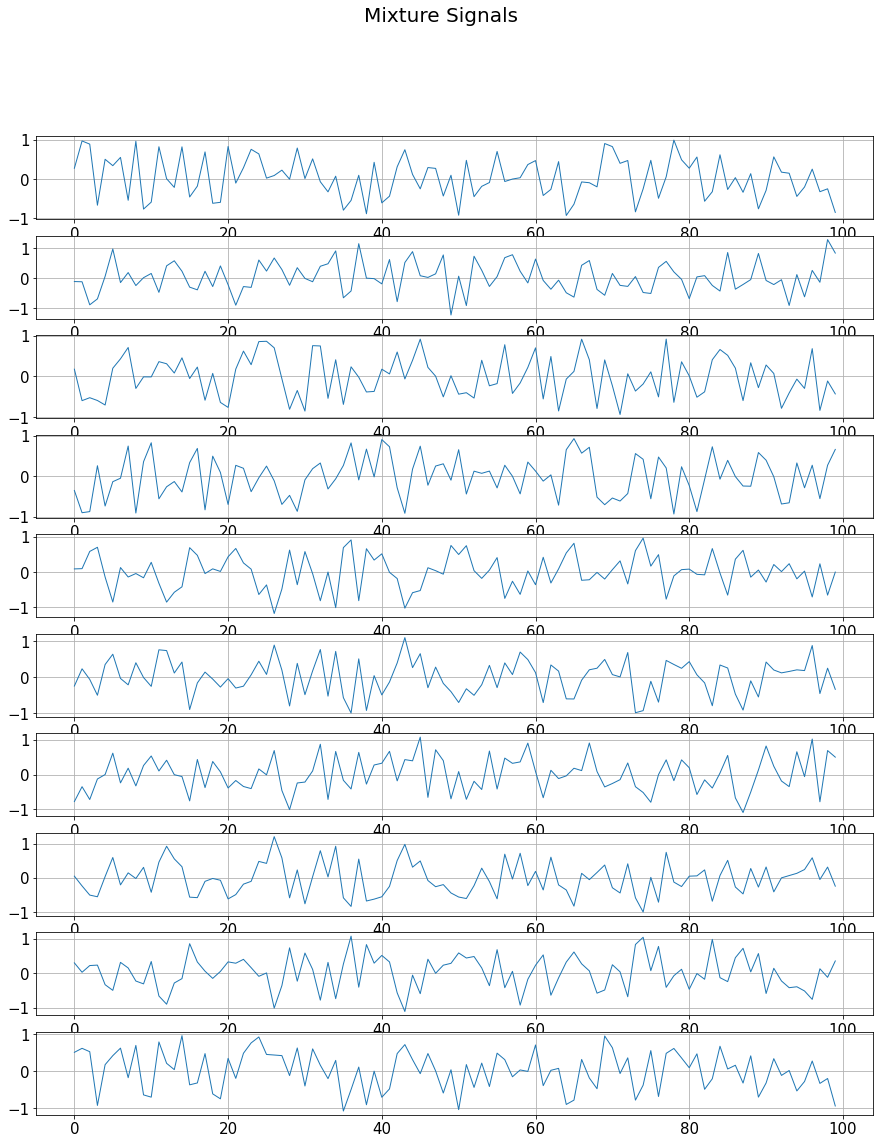

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [8,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1*1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

# Run WSM Algorithm on Mixture Signals

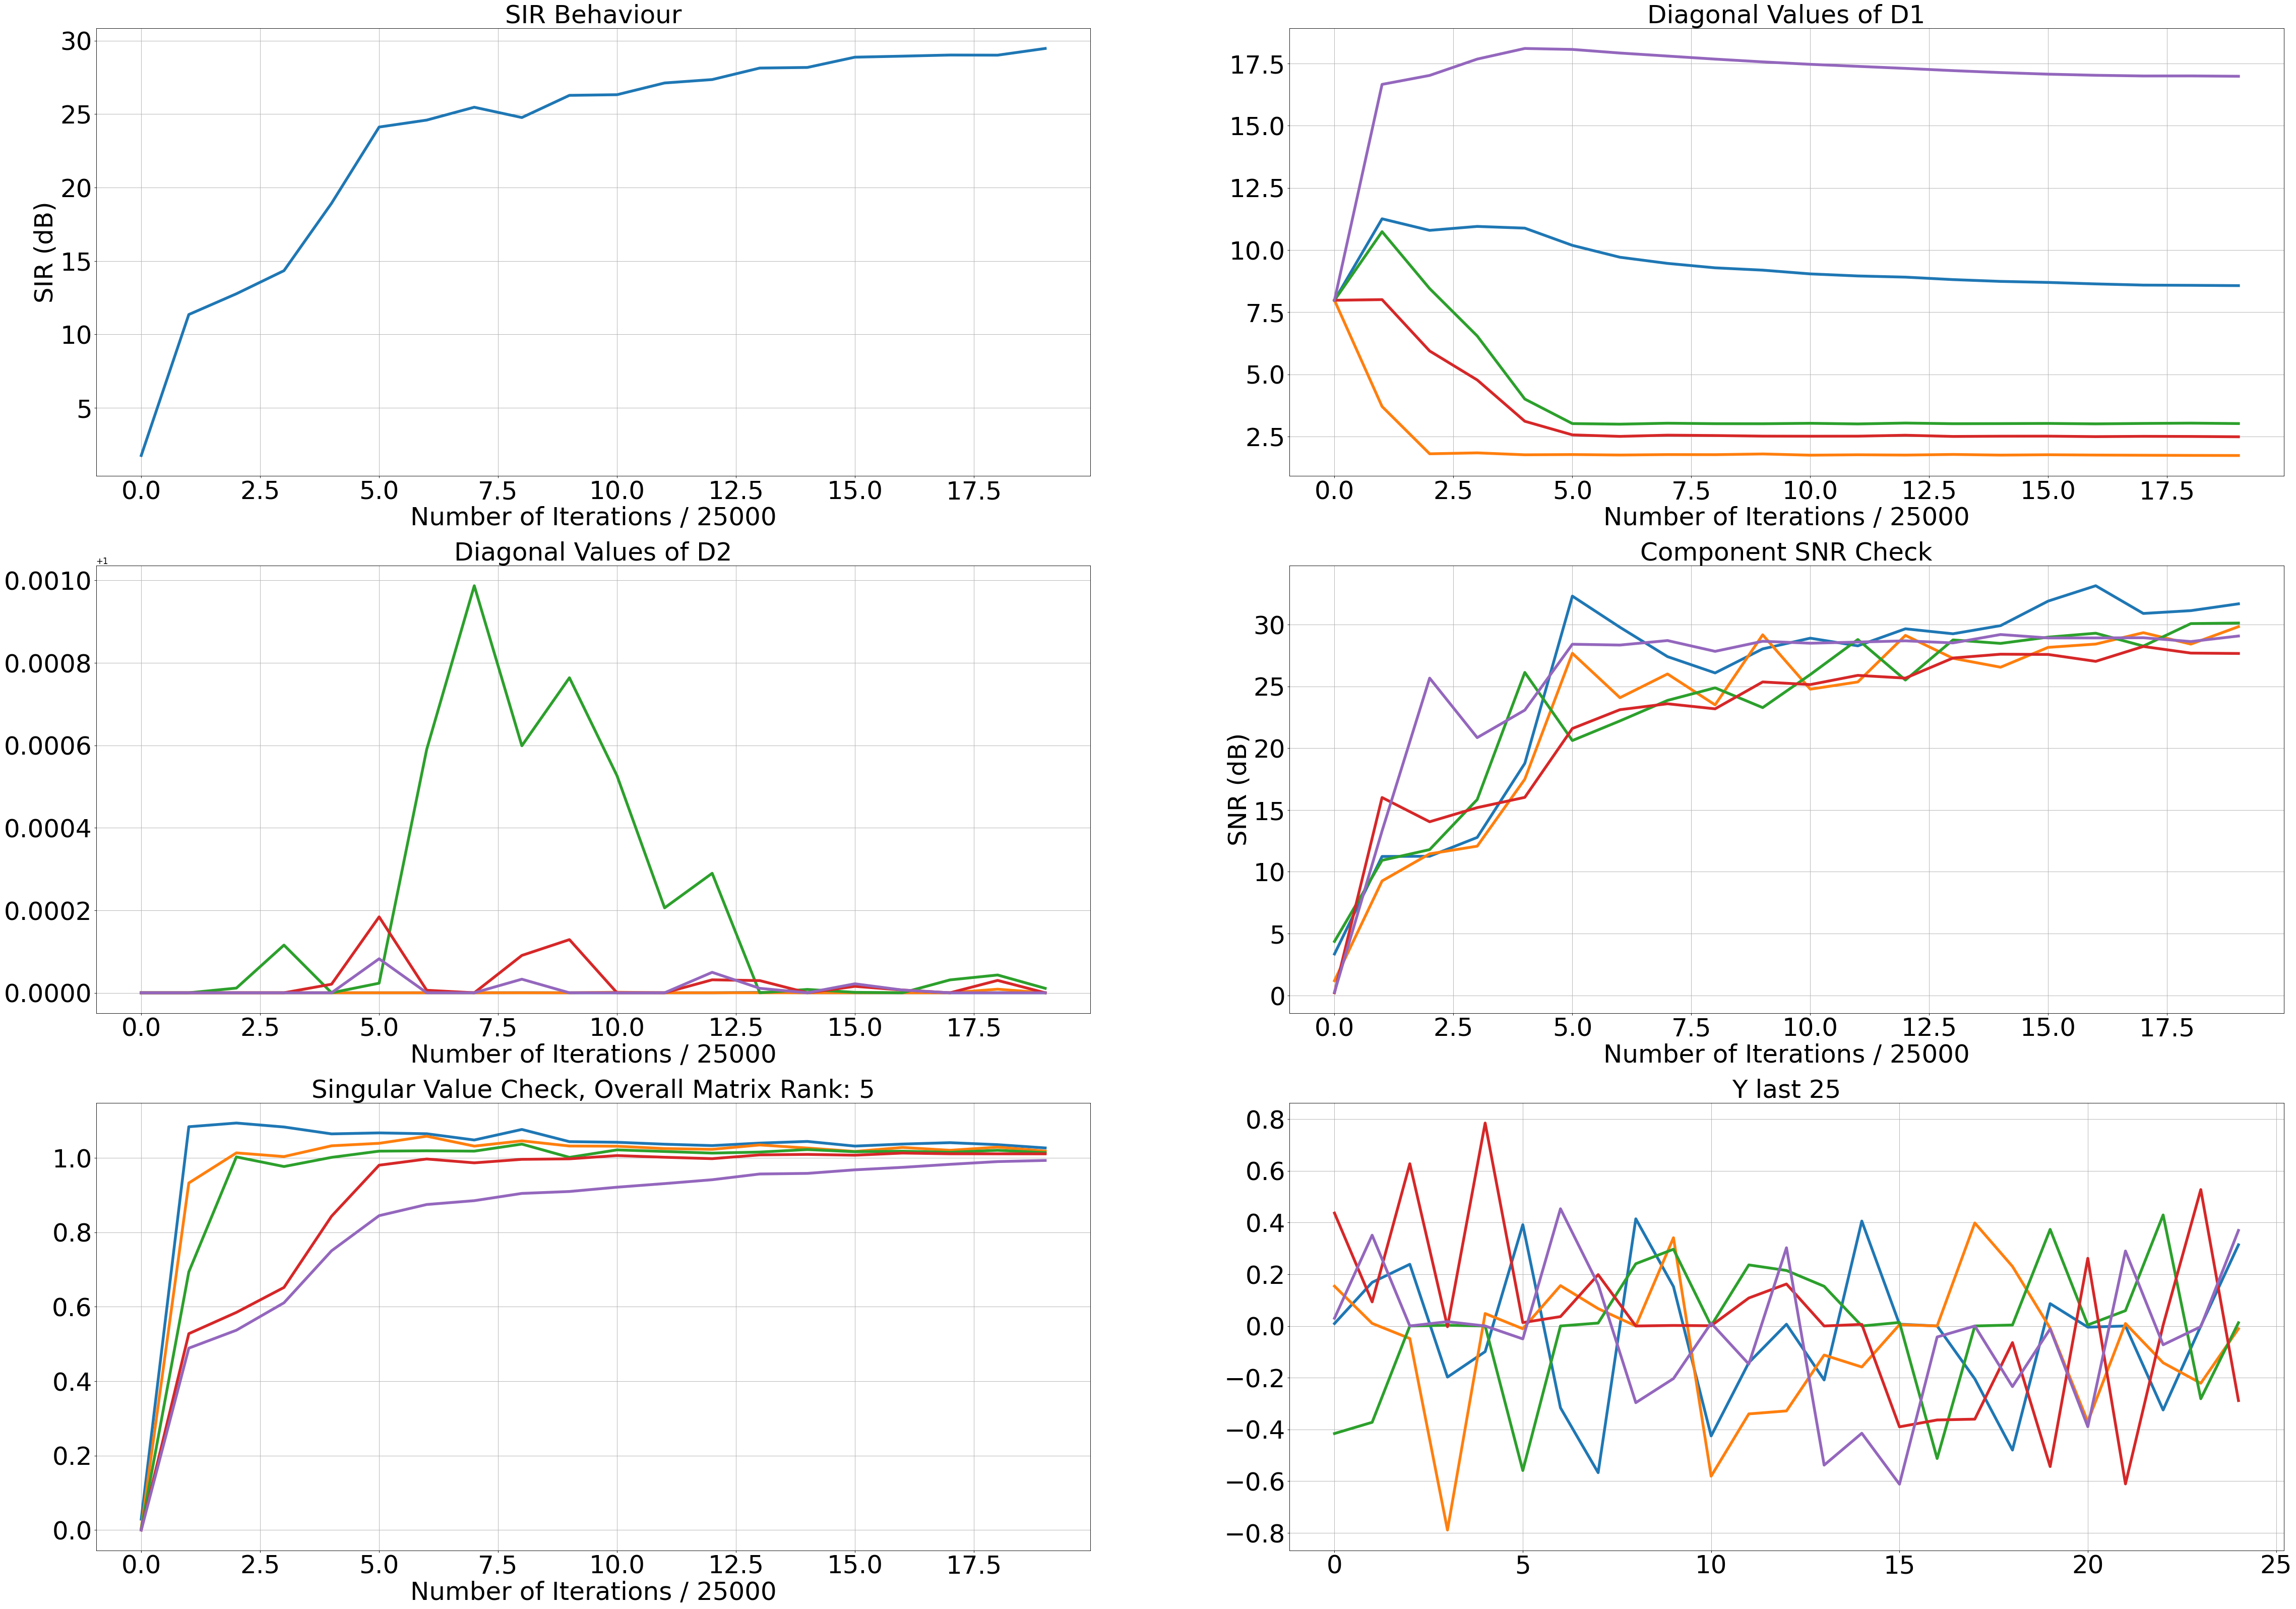

100%|██████████| 500000/500000 [32:52<00:00, 253.49it/s]


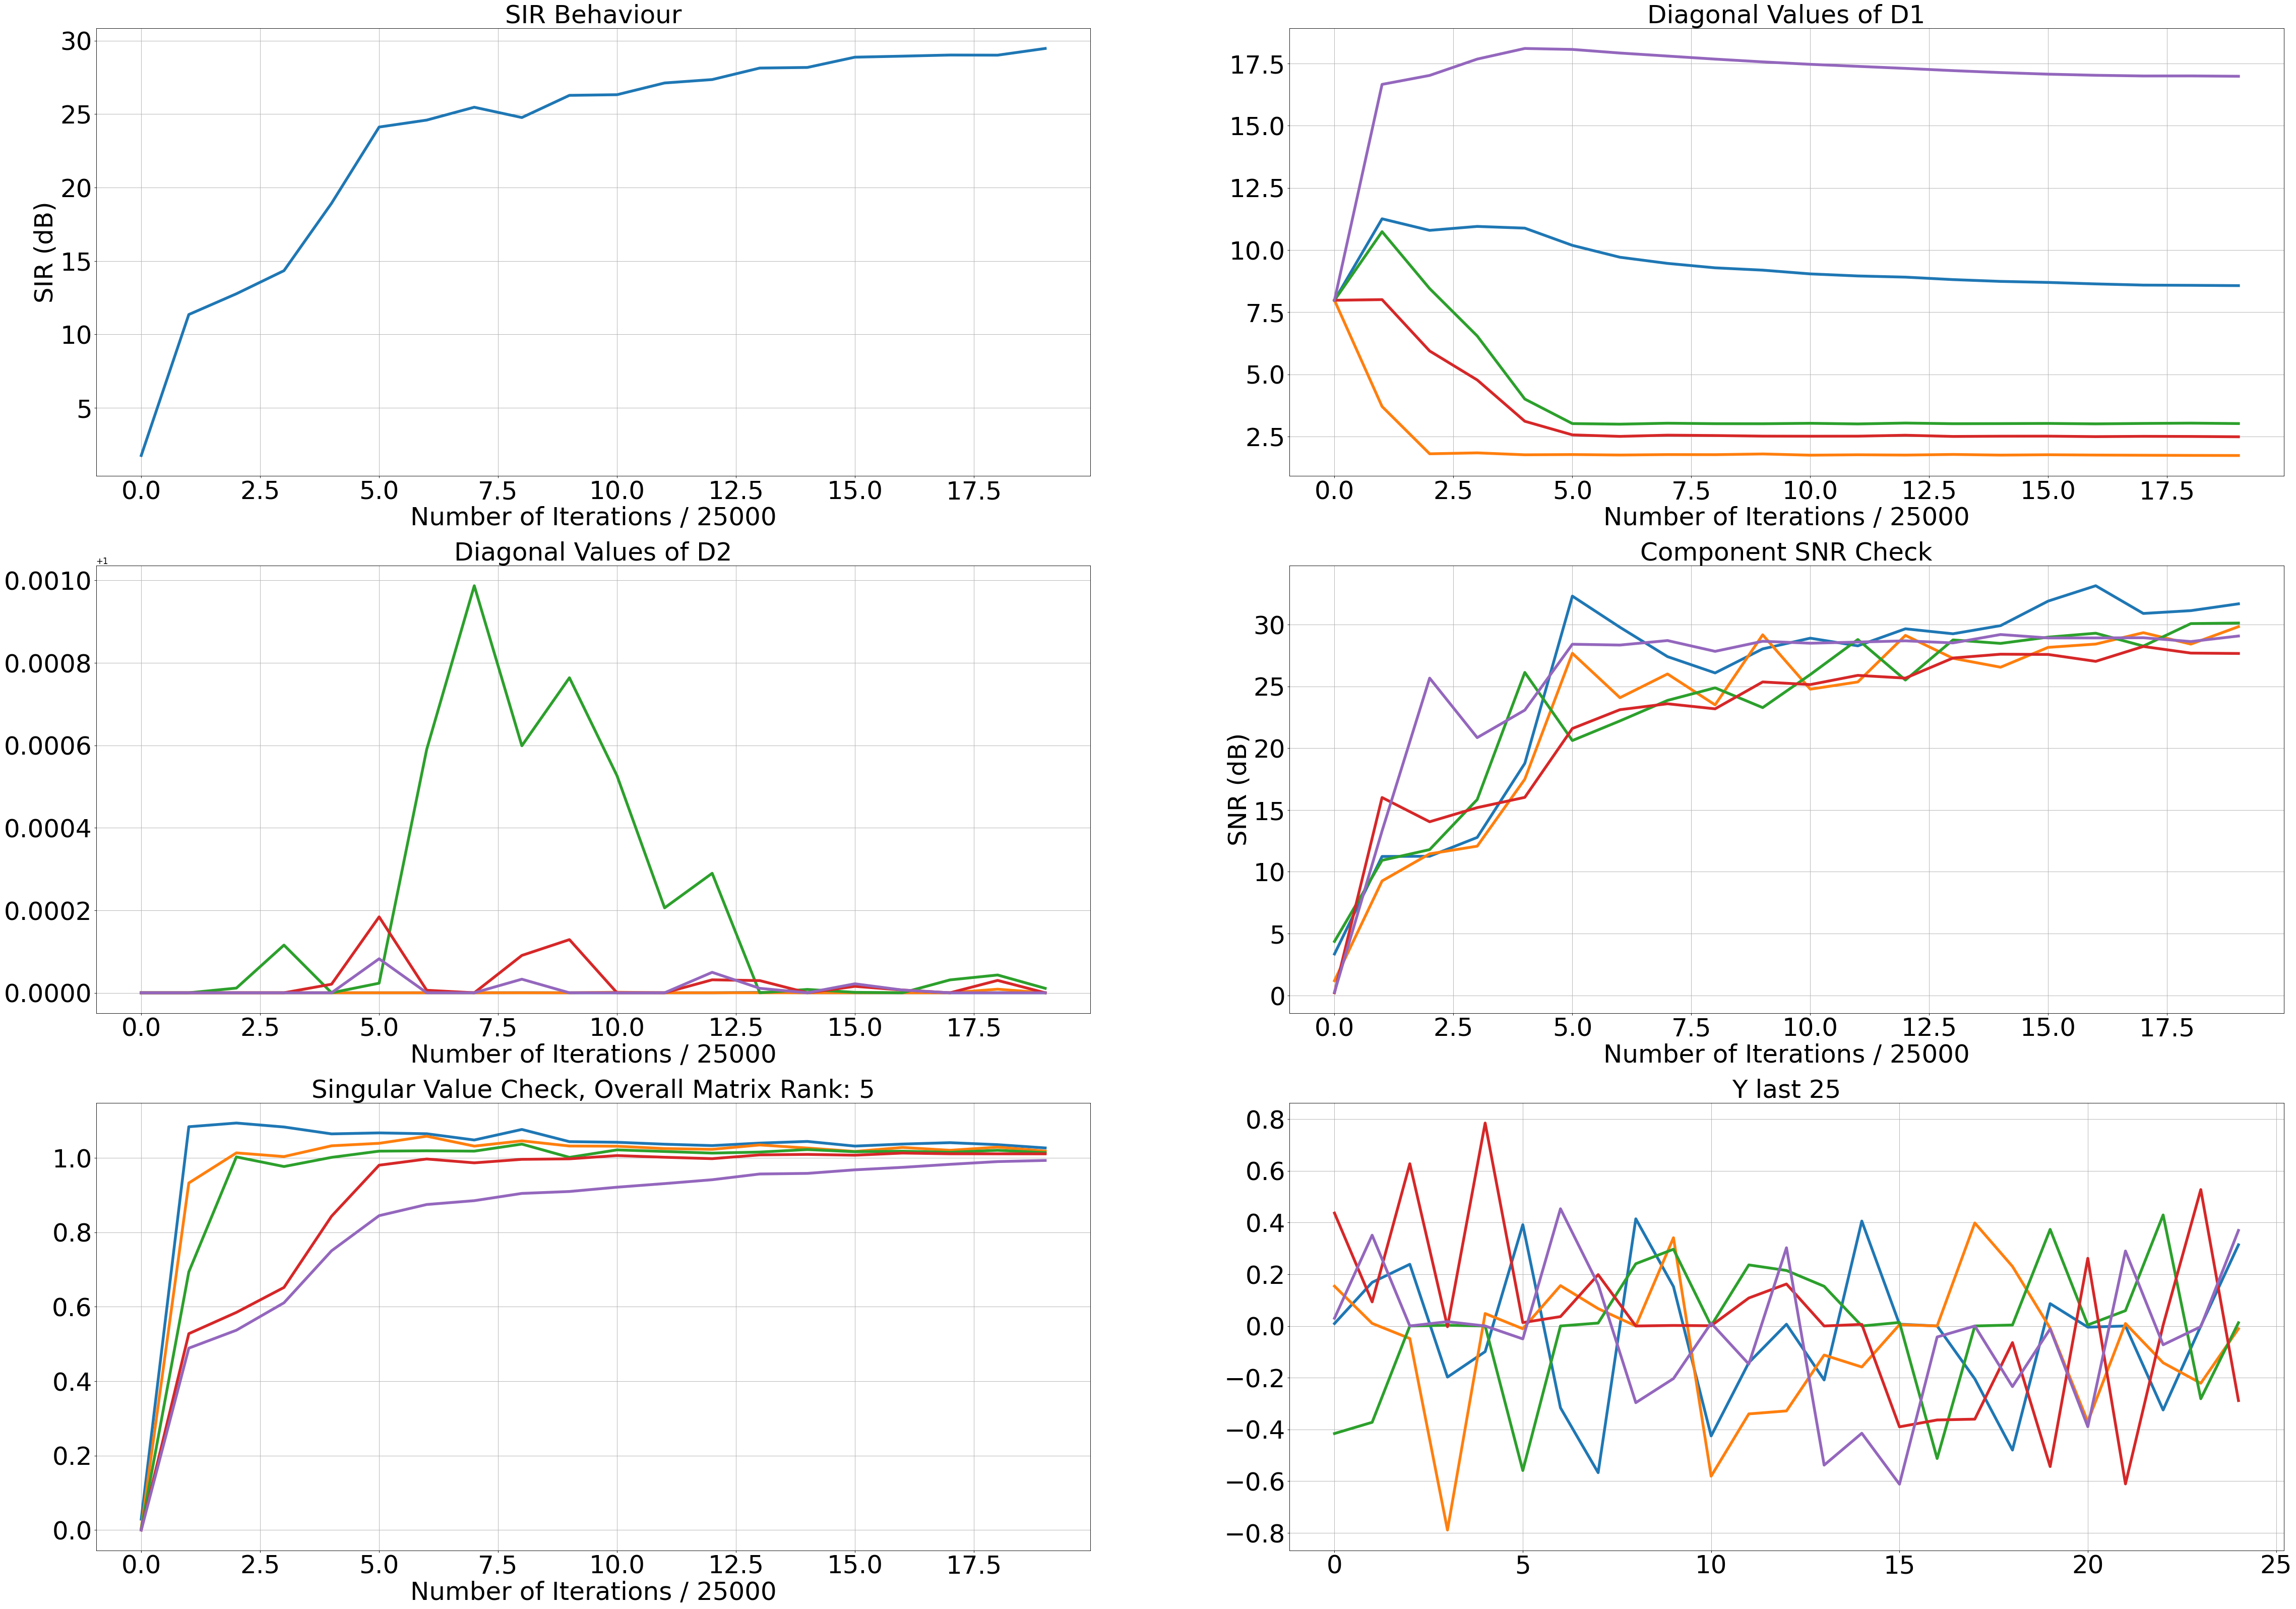

In [6]:
### TO REPLICATE THIS, CHANGE THE mat_factor6 in the neural dynamics to 
### mat_factor6 = (1 - zeta) * Gamma_Y * ((1 - beta) + beta * D2 ** 2)
### from mat_factor6 = Gamma_Y * D2


debug_iteration_point = 25000
modelWSM = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gamma_start = MUS, beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_sparse(X, n_epochs = 1, 
                          neural_lr_start = 0.25, neural_lr_stop = 0.25,
                          debug_iteration_point = debug_iteration_point,
                          plot_in_jupyter = True,
                         )

In [7]:
W = modelWSM.compute_overall_mapping(return_mapping = True)
Y_ = W @ X
Y_ = modelWSM.signed_and_permutation_corrected_sources(S,Y_)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_
self.Y_ = Y_


NameError: name 'self' is not defined

In [ ]:
np.sign((Y_ * S).sum(axis = 1))[:,np.newaxis].shape

In [ ]:
coef_

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

In [ ]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = modelWSM.signed_and_permutation_corrected_sources(Szeromean,Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, Szeromean)[0])

print("Overall SINR : {}".format(SINRwsm))

In [ ]:
Y_ = Wf @ X
snr_jit(S, Y_)

In [ ]:
display_matrix(Wf @ A)

In [ ]:
CalculateSIR(A, Wf)

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = modelWSM.signed_and_permutation_corrected_sources(S,Y)
10*np.log10(CalculateSINRjit(Y_, S)[0])

In [ ]:
perm = modelWSM.find_permutation_between_source_and_estimation(S,Y)
np.sign((Y[perm,:] * S).sum(axis = 1))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)